In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import collections
import sys
import os
import re
from matplotlib import pyplot as plt
from utils import *

In [2]:
total_playlists  = 0
total_tracks     = 0
playlist_titles  = list()
playlist_tracks  = list()
playlist_artists = list()
track_histogram  = collections.Counter()
artist_histogram = collections.Counter()
track2artist     = dict()
track2info       = dict()        

In [3]:
def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            mpd_slice = json.loads(js)
            for playlist in mpd_slice["playlists"]:
                process_playlist(playlist)
            count += 1
    

    
def process_playlist(playlist):
    global total_playlists, total_tracks

    total_playlists += 1
    nname = normalize_name(playlist["name"])
    playlist_titles.append(nname)
    
    tracks, artists = [], []
    for track in playlist["tracks"]:
        total_tracks += 1
        track_uri    = track["track_uri"].split(':')[2]
        tracks.append(track_uri)
        track_histogram[track_uri] += 1
        
        artist_uri = track["artist_uri"].split(':')[2]
        artists.append(artist_uri)
        artist_histogram[artist_uri] += 1
        track2artist[track_uri] = artist_uri
        track2info[track_uri]  = [track['track_name'], track['artist_name']]
        
    

    playlist_tracks.append(tracks)
    playlist_artists.append(artists)
    


def prune_ordered_histogram(hist, min_count):
    '''
    removes pairs that have frequency of appearance less than min_count
    hist -  dictionary ordered according to frequency (values)
    '''
    keys   = list(hist.keys())
    counts = list(hist.values())
    
    if min_count > 1:
        cutoff_idx = counts.index(min_count-1)
        del keys[cutoff_idx:]
        del counts[cutoff_idx:]
    return keys, counts
    

def change_uri_to_id(uris, uri_to_id_map):
    #get all track ids that are in the uri_to_id_map
    ids = []
    for cur_uri in uris:
        cur_id = uri_to_id_map.get(cur_uri, -1)
        if cur_id == -1:
            continue
        ids.append(cur_id)
    return ids

In [4]:
process_mpd(orig_data_dir)

In [5]:
MIN_TRACK_FREQ   = 300 #15

#remove all tracks that appear less than MIN_TRACK_FREQ times within the whole training set
track_uris, track_freq = prune_ordered_histogram(collections.OrderedDict(track_histogram.most_common()), MIN_TRACK_FREQ)
track_count = len(track_uris)

#new uri to id mapping with tracks that appear at least MIN_TRACK_FREQ times
track_uri_to_id = dict(zip(track_uris, range(0, track_count)))

print('After filtering, number of tracks = %d' %(track_count))

#Save track information
pruned_id_to_info = dict()
for track_uri in track_uris:
    pruned_id_to_info[track_uri_to_id[track_uri]] = track2info[track_uri]

with open(train_data_dir+'/'+'id_to_info', 'w') as info_file:
    json.dump(pruned_id_to_info, info_file, indent="\t")

After filtering, number of tracks = 26709


In [6]:
MIN_ARTIST_FREQ  = 300 #15

#remove all artists that appear less than MIN_TRACK_FREQ times within the whole training set
artist_uris, artist_freq = prune_ordered_histogram(collections.OrderedDict(artist_histogram.most_common()), MIN_ARTIST_FREQ)
artist_count = len(artist_uris)
artist_uri_to_id = dict(zip(artist_uris, range(0, artist_count)))

print('After filtering, number of artists = %d' %(artist_count))

After filtering, number of artists = 12018


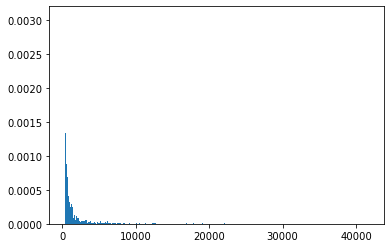

In [7]:
plt.hist(track_freq, bins = 10000, density = True)
plt.show()
#print(list(track_histogram.values())[:100])

In [8]:
playlists      = []
all_track_uris = set()
for tracks_uris, artists_uris, title in zip(playlist_tracks, playlist_artists, playlist_titles):
    tracks_ids  = change_uri_to_id(tracks_uris, track_uri_to_id)
    artists_ids = change_uri_to_id(artists_uris, artist_uri_to_id)
    all_track_uris.update(tracks_uris)
    if len(tracks_ids) == 0 and len(artists_ids) == 0:
        continue
    if len(tracks_ids) > 250 or len(artists_ids) > 250:
        continue
    title_char_indices = title_to_indices(title, MAX_TITLE_LEN)
    playlists.append([tracks_ids, artists_ids, title_char_indices])

print('Total number of playlists %d' %len(playlists))


Total number of playlists 897959


In [9]:
#save training set       
file_data = dict()
file_data['max_title_len']    = MAX_TITLE_LEN
file_data['num_char']         = NUM_CHAR
file_data['all_track_uris']   = list(all_track_uris)

file_data['track_uri_to_id']  = track_uri_to_id
file_data['artist_uri_to_id'] = artist_uri_to_id
file_data['char_to_idx']      = char_to_idx

file_data['playlists']        = playlists

print('train')
with open(train_json, 'w') as make_file:
    json.dump(file_data, make_file, indent="\t")
print("num playlists: %d,  tracks>=min_count: %d, artists>=min_count: %d" %
      (len(playlists), len(track_uri_to_id), len(artist_uri_to_id)))
print('Num of tracks before filtering tracks %d' % (len(file_data['all_track_uris'])))

train
num playlists: 897959,  tracks>=min_count: 26709, artists>=min_count: 12018
Num of tracks before filtering tracks 2150612
